In [159]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc, integrated_brier_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import sys
import scanpy as sc
import anndata
sys.path.append('../scripts')  

import plotting_utils as mplt
sys.path.append('../notebooks')  



In [160]:
# load processed dataframes
metadata_df = pd.read_csv('../data/cancer_metadata.csv', index_col=0)
expression = pd.read_csv('../data/cancer_tmm_log.csv', index_col=0)

os.makedirs("../results/cancer_survival", exist_ok=True)
# %% AUC Plotting function to be used later
def plot_auc(model_name, y_train, y_test, preds, intervals):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, preds, intervals)
    plt.figure()
    plt.plot(intervals, auc, marker="o", label=f"{model_name} (mean AUC = {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--", color='gray')
    plt.xlabel("Years from enrollment")
    plt.ylabel("Time-dependent AUC")
    plt.title(f"{model_name} - Time-dependent AUC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/cancer_survival/{model_name}_auc_plot.png")
    plt.show()
    plt.close()
    return auc, mean_auc


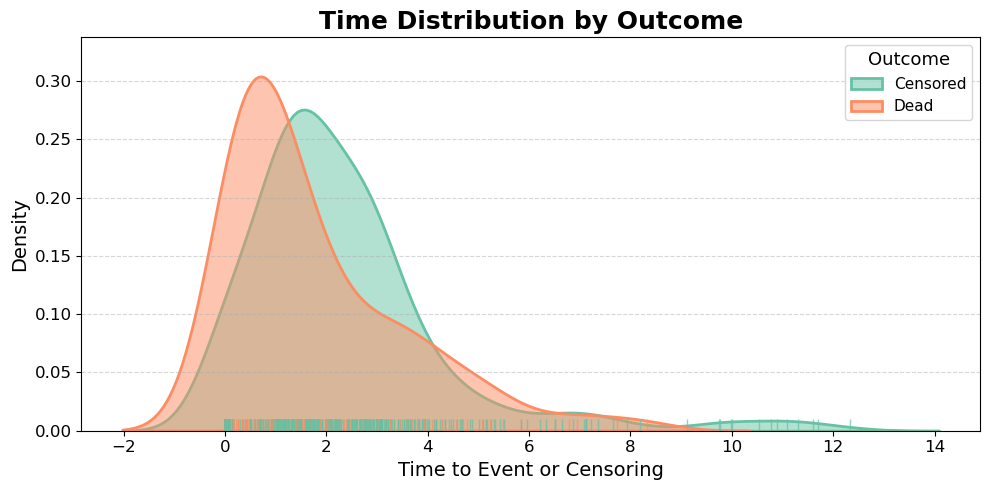

In [161]:
mplt.plot_time_distribution_by_outcome(metadata_df, time_col='os_time', status_col='os_status')

In [163]:
final_df = metadata_df.merge(expression, left_index=True, right_index=True)
# splitting X and y and preparing right format for scikit survival 
y = final_df[['os_status','os_time']]
y = np.array(
    list(zip(
        y['os_status'].astype(bool),
        y['os_time']
    )),
    dtype=[('os_status', '?'), ('os_time', '<f8')]
)

X = final_df.drop(columns=['os_status', 'os_time'])

In [167]:
# Example: split metadata_df into train and test
train_df, test_df, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y['os_status'])

# Separate categorical and numeric columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
numeric_cols = train_df.select_dtypes(include=['number']).columns

# ---- 1. Label Encoding ----
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()

    # Fit on train (ignoring NaNs)
    train_df[col] = train_df[col].astype(str).replace('nan', np.nan)
    not_null_mask_train = train_df[col].notnull()
    train_df.loc[not_null_mask_train, col] = le.fit_transform(train_df.loc[not_null_mask_train, col])

    # Transform test using the same encoder
    test_df[col] = test_df[col].astype(str).replace('nan', np.nan)
    not_null_mask_test = test_df[col].notnull()
    test_df.loc[not_null_mask_test, col] = le.transform(test_df.loc[not_null_mask_test, col])

    # Save encoder
    label_encoders[col] = le

# ---- 2. Scaling ----
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# ---- 3. Iterative Imputer (MICE) ----
mice_imputer = IterativeImputer()

train_imputed = mice_imputer.fit_transform(train_df)
test_imputed = mice_imputer.transform(test_df)

# Convert back to DataFrame
X_train = pd.DataFrame(train_imputed, columns=train_df.columns, index=train_df.index)
X_test = pd.DataFrame(test_imputed, columns=test_df.columns, index=test_df.index)


MemoryError: Unable to allocate 2.58 GiB for an array with shape (18603, 18603) and data type float64

In [ ]:
# selecting 30 best features
bestk = SelectKBest(score_func=f_classif, k=200)
bestk.fit(X_train, y_train)
X_train = bestk.transform(X_train)
X_test = bestk.transform(X_test)
selected_feature_names = X_train.columns[bestk.get_support()]

In [ ]:
# # custom wrapper function for survival model tuning
def c_index_scorer(estimator, X,y):
    surv_pred = estimator.predict(X)
    result = concordance_index_censored(y['os_status'], y['os_time'], surv_pred)
    return result[0]

# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,400,500],
    "max_depth": [2,3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2"]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=3,
    scoring=c_index_scorer,
    random_state=42
)

# 6. Fit the model
random_search.fit(X_train, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)
print("Bestaccuracy on training data:", random_search.best_score_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
rsf_predict = best_rsf.predict(X_test)

Best Parameters: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 15}
Bestaccuracy on training data: 0.0


In [ ]:
# plotting auc
y_min,y_max = np.min(y_test['os_time']), np.max(y_test['os_time'])
intervals = np.arange(y_min+1,y_max,1)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals)

In [ ]:
# define the gradient boosting forest model
gbs = GradientBoostingSurvivalAnalysis(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "learning_rate" : [0.01,0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbs,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# Fit the model
random_search.fit(X_train, y_train)

# View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# Use the best model
best_gbs = random_search.best_estimator_
gbs_predict = best_gbs.predict(X_test)

KeyboardInterrupt: 

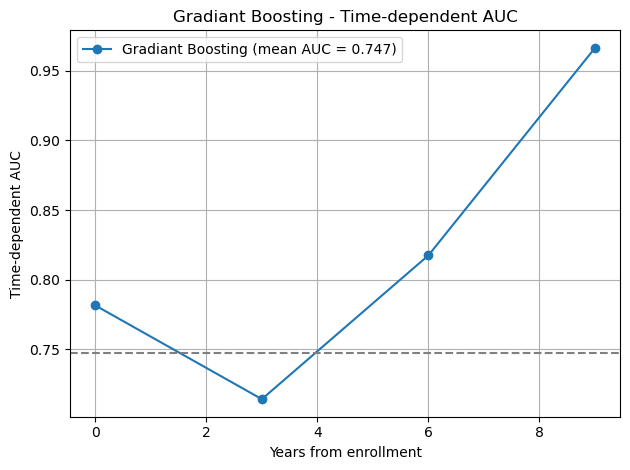

(array([0.7816092 , 0.71433435, 0.81752874, 0.96638655]), 0.7474944718101103)

In [ ]:
# plot AUC

plot_auc('Gradiant Boosting',y_train,y_test,gbs_predict,intervals)

In [ ]:
# model evaluation with c index and brier score

rsf_surv_prob = np.vstack([fn(intervals) for fn in best_rsf.predict_survival_function(X_test)])
gbs_surv_prob = np.vstack([fn(intervals) for fn in best_gbs.predict_survival_function(X_test)])

score_cindex = pd.Series(
    [
        best_rsf.score(X_test, y_test),
        best_gbs.score(X_test, y_test),
    ],
    index=["RSF", "GBS"],
    name="c-index",
)
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, intervals)
        for prob in (rsf_surv_prob, gbs_surv_prob)
    ],
    index=["RSF", "GBS"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)


,c-index,IBS
RSF,0.610,0.089
GBS,0.629,0.093


In [ ]:
hello

In [ ]:
count_df = pd.read_csv('../data/cancer_expression.csv', index_col=0)
scaled_df = pd.read_csv("../data/cancer_scaled_expression.csv", index_col=0)
run_pipeline(count_df, metadata_df, scaled_df,
                 ['os_status','age','gender'],('os_status','Censored','Dead'), '../results/cancer_gsea', '../data/hallmarks.gmt')

🔹 Running DESeq2...


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.77 seconds.

Fitting dispersions...
... done in 14.68 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 16.85 seconds.

Fitting LFCs...
... done in 9.35 seconds.

Calculating cook's distance...
... done in 1.08 seconds.

Replacing 476 outlier genes.

Fitting dispersions...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 0.44 seconds.

Fitting LFCs...
... done in 0.57 seconds.

Running Wald tests...
... done in 2.44 seconds.



Log2 fold change & Wald test p-value: os_status Censored vs Dead
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG          1.277274        0.018204  0.160902  0.113137  0.909922  0.997562
A1BG-AS1      7.934905        0.089681  0.113570  0.789652  0.429731  0.810171
A1CF        689.276702       -0.055320  0.107543 -0.514400  0.606972  0.933666
A2M       12116.061321       -0.041588  0.102175 -0.407026  0.683989  0.976527
A2M-AS1      13.932475       -0.062335  0.098217 -0.634661  0.525649  0.882244
...                ...             ...       ...       ...       ...       ...
ZYG11A        3.483182       -0.125382  0.190105 -0.659540  0.509549  0.871385
ZYG11B      835.534982        0.066112  0.049397  1.338392  0.180769  0.540711
ZYX        7459.225845       -0.021385  0.067753 -0.315636  0.752279  0.997562
ZZEF1      2092.553990        0.081540  0.063138  1.291452  0.196547  0.559407
ZZZ3       1177.431751        0.055294  0.042775  1.292671  0.1961

2025-08-09 11:04:55,798 [WARNING] Duplicated values found in preranked stats: 0.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


🔹 Running GSEA prerank...
✅ Pipeline complete.
Top enriched pathways:
      Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank          ATM_DN.V1_UP -0.455394 -1.702178       0.0  0.035394   
1  prerank  KRAS.KIDNEY_UP.V1_UP  -0.47774 -1.698116       0.0  0.017697   
2  prerank      RB_P107_DN.V1_UP  0.339173   1.64367       0.0  0.046388   
3  prerank       SIRNA_EIF4GI_UP  0.379908  1.624948       0.0  0.023194   
4  prerank     KRAS.300_UP.V1_UP -0.444654 -1.604731       0.0  0.067839   

  FWER p-val   Tag %  Gene %  \
0       0.04  37/142  10.81%   
1       0.04  67/135  25.38%   
2       0.02  43/127  15.45%   
3       0.02   40/88  22.85%   
4       0.19  55/136  20.04%   

                                          Lead_genes  
0  TNNT3;BDNF;NGFR;RPE65;ENO3;TTR;MYOM1;GCM1;FGF5...  
1  PCDH9;SLC6A15;ERC2;CRYAB;SFRP1;SNAP25;SLC6A1;C...  
2  DCT;CCNF;ETHE1;MAD2L1;PRIM1;NXT1;PRDX4;GMNN;AN...  
3  ASAH1;UBE2E1;NSG1;KIF2A;SLC25A5;FCAR;UQCRC2;HL...  
4  SL

In [ ]:
pre_res= pd.read_csv('../results/cancer_gsea/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
scaled_df_filtered = scaled_df.loc[:, scaled_df.columns.isin(unique_genes)]

scaled_df_filtered.shape

(609, 1830)

In [ ]:
noncoded_metadata =  pd.read_csv('../data/metadata.csv', index_col = 0).loc[metadata_df.index]

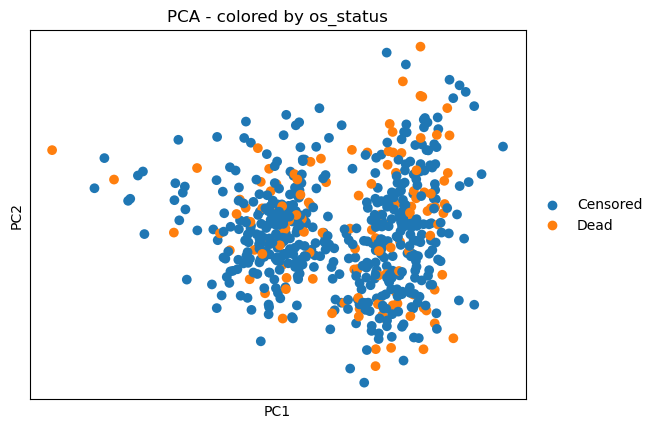

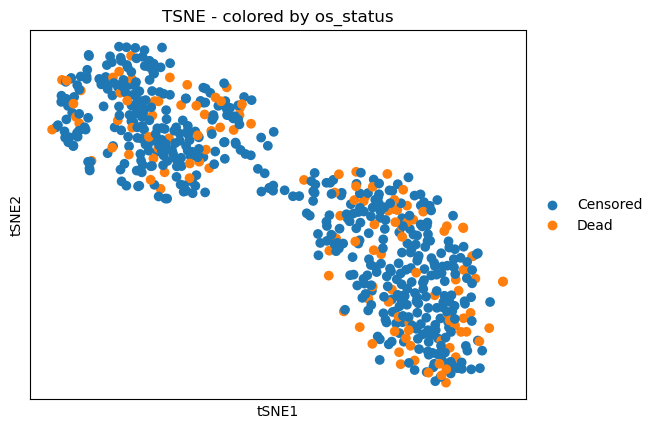

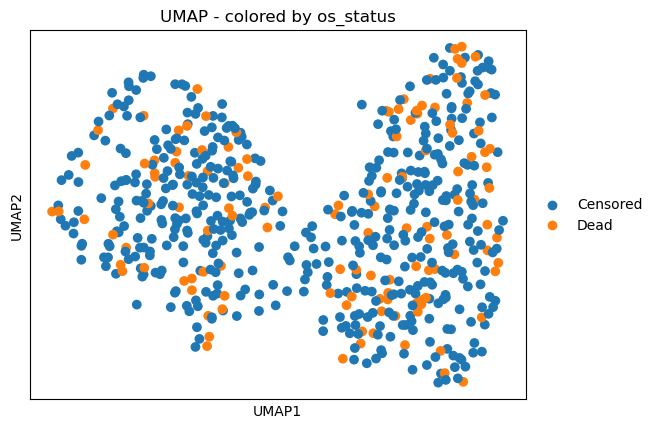

In [ ]:
# This filters expression data to tumor samples only
cancer_adata = anndata.AnnData(scaled_df_filtered)


# Add all columns from metadata_df to adata.obs
for col in noncoded_metadata.columns:
    cancer_adata.obs[col] = noncoded_metadata[col]


# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

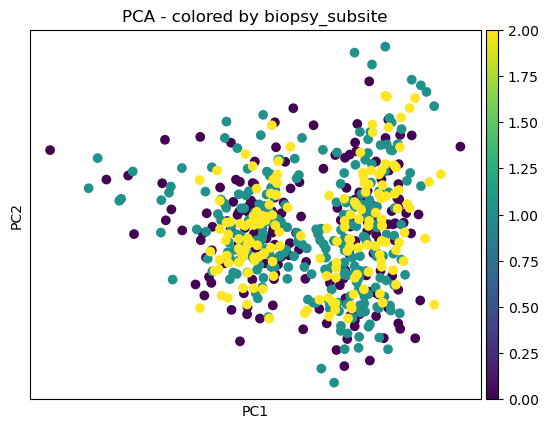

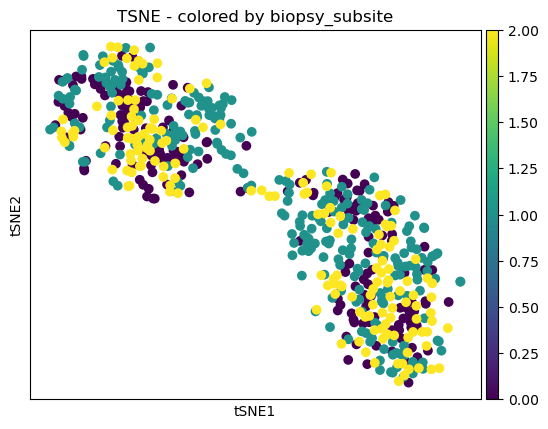

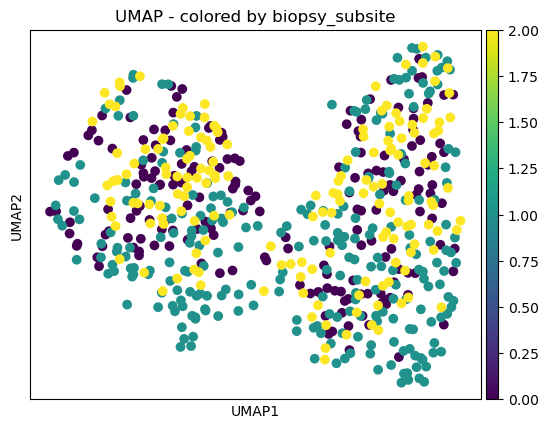

In [ ]:
#plotting by histological_subtype
mplt.plot_reductions(cancer_adata, 'biopsy_subsite')

leiden
0    338
1    271
Name: count, dtype: int64


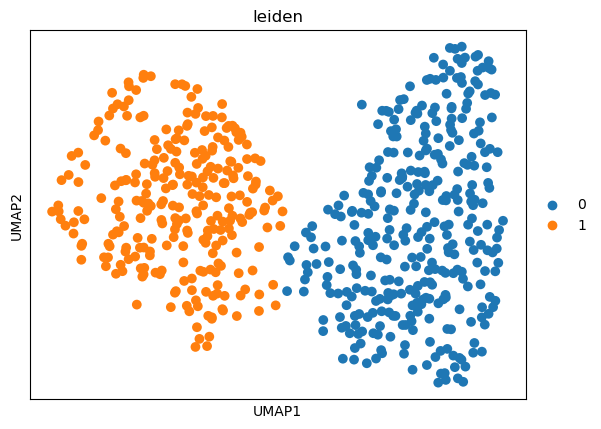

In [ ]:
sc.pp.neighbors(cancer_adata, use_rep='X_umap') 
sc.tl.leiden(cancer_adata, resolution=0.05)     

# Add Leiden clusters to metadata
print(cancer_adata.obs['leiden'].value_counts())

# Plot UMAP with Leiden clusters
sc.pl.umap(cancer_adata, color=['leiden'])

In [ ]:
from sklearn.metrics import adjusted_rand_score

if 'leiden' in cancer_adata.obs.columns:
    ref = cancer_adata.obs['leiden'].astype(str).values
    scores = {}
    for col in cancer_adata.obs.columns:
        vals = cancer_adata.obs[col].astype(str).values
        try:
            scores[col] = adjusted_rand_score(ref, vals)
        except Exception:
            scores[col] = np.nan
    # rank columns by similarity to 'leiden'
    print(sorted(scores.items(), key=lambda x: - (x[1] if x[1] is not None else -1))[:10])
print(scores)

[('leiden', 1.0), ('molecular_type', 0.4660743501474389), ('tmb', 0.0343083764585912), ('therapy_response', 0.01517764869925514), ('cms', 0.0075028133945646515), ('histological_type', 0.005575417998601207), ('tp53_mutation', 0.0025518913568774587), ('os_time', 0.0023504096247995297), ('prior_treatment', 0.001782936771325841), ('biopsy_subsite', 0.001435906469942469)]
{'age': -0.00039220787703724745, 'biopsy_subsite': 0.001435906469942469, 'braf_mutation': -0.004604189413526254, 'biopsy_site': -0.0010799581966297977, 'biopsy_timepoint': 0.0, 'cms': 0.0075028133945646515, 'distal_vs_proximal': -0.000669846633613992, 'egfr_mutated': -0.002740992966865276, 'grade': 0.0, 'histological_subtype': -0.003289638895924265, 'histological_type': 0.005575417998601207, 'kras_mutation': -0.0028132344033802072, 'msi_status': -0.0022832731074784365, 'molecular_type': 0.4660743501474389, 'os_status': -0.004925230974088021, 'os_time': 0.0023504096247995297, 'primary_site': -0.0010799581966297977, 'prior_t

In [ ]:
umap_values = cancer_adata.obsm['X_umap']
umap_df = pd.DataFrame(
    umap_values,
    index=cancer_adata.obs_names,
    columns=['UMAP1', 'UMAP2']
)
metadata_df_filtered = metadata_df.drop(columns=['os_status','os_time','age'])
# Re-wrap into DataFrames for easier plotting and model interpretation
X =umap_df.merge(metadata_df_filtered, left_index=True, right_index=True, how='left')


# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# selecting 30 best features
bestk = SelectKBest(score_func=f_classif, k=10)
bestk.fit(X_train, y_train)
selected_feature_names = X_train.columns[bestk.get_support()]

X_train_selected = pd.DataFrame(bestk.transform(X_train), columns=selected_feature_names, index=X_train.index)
X_test_selected = pd.DataFrame(bestk.transform(X_test), columns=selected_feature_names, index=X_test.index)



In [ ]:
# custom wrapper function for survival model tuning
def c_index_scorer(estimator, X,y):
    surv_pred = estimator.predict(X)
    result = concordance_index_censored(y['os_status'], y['os_time'], surv_pred)
    return result[0]

# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2",  None]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# 6. Fit the model
random_search.fit(X_train_selected, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
rsf_predict = best_rsf.predict(X_test_selected)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 3}
Best C-index on training data: 0.5809408899916486


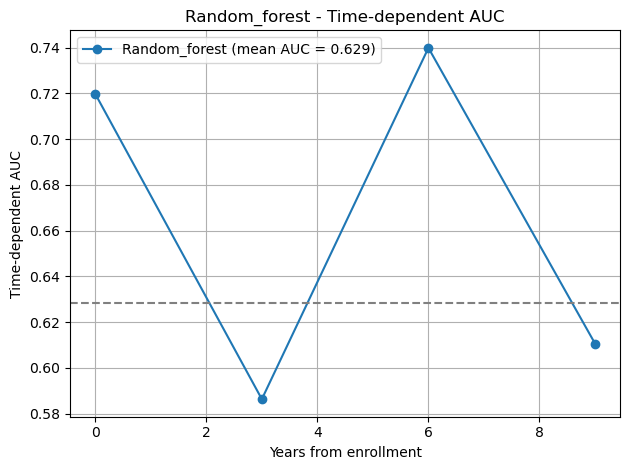

(array([0.71982759, 0.58631256, 0.73994253, 0.61064426]), 0.6285150366805625)

In [ ]:
# plotting auc
y_min,y_max = np.min(y_test['os_time']), np.max(y_test['os_time'])
intervals = np.arange(y_min,y_max,3)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals)

In [ ]:
# define the gradient boosting forest model
gbs = GradientBoostingSurvivalAnalysis(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "learning_rate" : [0.01,0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbs,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# Fit the model
random_search.fit(X_train_selected, y_train)

# View best params
print("Best Parameters:", random_search.best_params_)
print("Best C-index on training data:", random_search.best_score_)

# Use the best model
best_gbs = random_search.best_estimator_
gbs_predict = best_gbs.predict(X_test_selected)

KeyboardInterrupt: 

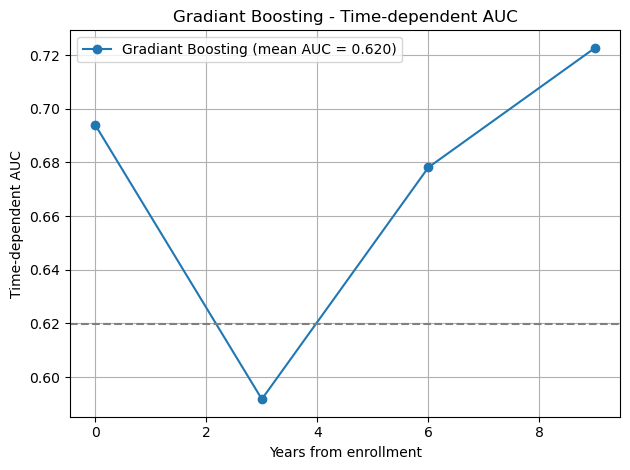

(array([0.69396552, 0.5917603 , 0.67816092, 0.72268908]), 0.6198177313179757)

In [ ]:
# plot AUC

plot_auc('Gradiant Boosting',y_train,y_test,gbs_predict,intervals)

In [ ]:
# model evaluation with c index and brier score

rsf_surv_prob = np.vstack([fn(intervals) for fn in best_rsf.predict_survival_function(X_test_selected)])
gbs_surv_prob = np.vstack([fn(intervals) for fn in best_gbs.predict_survival_function(X_test_selected)])

score_cindex = pd.Series(
    [
        best_rsf.score(X_test_selected, y_test),
        best_gbs.score(X_test_selected, y_test),
    ],
    index=["RSF", "GBS"],
    name="c-index",
)
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, intervals)
        for prob in (rsf_surv_prob, gbs_surv_prob)
    ],
    index=["RSF", "GBS"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)


,c-index,IBS
RSF,0.580,0.094
GBS,0.573,0.108


In [ ]:
hello

NameError: name 'hello' is not defined

In [ ]:
def plot_permutation_importance(model, X_test, y_test, model_name='Model', n_repeats=100, random_state=42):
    """
    Computes and plots permutation importance for a fitted model.

    Parameters:
    - model: Fitted model (e.g., RandomSurvivalForest or GradientBoostingSurvivalAnalysis)
    - X_test: Test features (DataFrame)
    - y_test: Test target
    - model_name: Name to display in plot title
    - n_repeats: Number of permutations (default=100)
    - random_state: Random seed for reproducibility
    """
    result = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=random_state)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title(f'Permutation Importance - {model_name}')
    fig.tight_layout()
    plt.show()
    

plot_permutation_importance(best_rsf, X_test_selected, y_test, model_name='RSF')
plot_permutation_importance(best_gbs, X_test_selected, y_test, model_name='GBS')


KeyboardInterrupt: 